In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/drive/My Drive/'
por = np.loadtxt(path + 'por.txt')
res = np.loadtxt(path + 'res.txt')
swat = np.loadtxt(path + 'swat.txt')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
res_log = np.log(res)

In [ ]:
raw_dataset = pd.DataFrame({'por':por, 'res':res_log, 'swat':swat})
dataset = raw_dataset.copy()
dataset.tail()

,por,res,swat
179995,0.074607,2.417698,0.92512
179996,0.074607,2.417698,0.92512
179997,0.074607,2.309561,0.92512
179998,0.068916,1.635106,0.79184
179999,0.068916,1.635106,0.79184


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

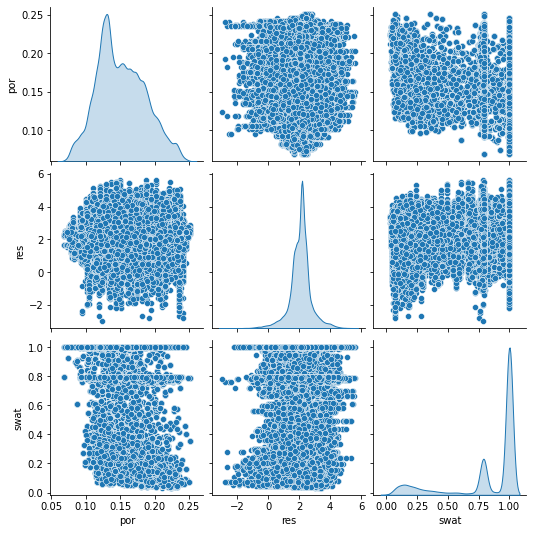

In [ ]:
sns.pairplot(train_dataset[["por", "res", "swat"]], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("swat")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
por,144000.0,0.151216,0.034769,0.068508,0.125510,0.147540,0.176110,0.251250
res,144000.0,2.064269,0.706466,-2.995732,1.733424,2.118662,2.387845,5.604109


In [ ]:
train_labels = train_dataset.pop('swat')
test_labels = test_dataset.pop('swat')

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 5,555
Trainable params: 5,555
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example_batch = np.array([train_dataset.por[:10], train_dataset.res[:10]]).transpose()
example_batch

array([[ 0.19047   ,  1.67709656],
       [ 0.13867   ,  3.84331581],
       [ 0.10817   ,  2.4518668 ],
       [ 0.20291   , -0.16251893],
       [ 0.12436   ,  2.26072089],
       [ 0.13154   ,  3.42654019],
       [ 0.087369  ,  1.57277393],
       [ 0.15879   ,  2.31352503],
       [ 0.11213   ,  2.2300144 ],
       [ 0.12073   ,  1.84687877]])

In [ ]:
example_result = model.predict(example_batch)
example_result

array([[-0.01042181],
       [-0.01302836],
       [-0.0090297 ],
       [-0.00334838],
       [-0.00922318],
       [-0.01190375],
       [-0.00644759],
       [-0.01058763],
       [-0.00871373],
       [-0.00823224]], dtype=float32)

In [ ]:
train_data = np.array([train_dataset.por[900:], train_dataset.res[900:]]).transpose()
norm_train_labels = np.array(train_labels[900:])

In [ ]:
# Выведем прогресс обучения в виде точек после каждой завершенной эпохи
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

history = model.fit(
  train_data, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,0.084420,0.222295,0.084420,0.074588,0.217473,0.074588,0
1,0.075415,0.205720,0.075415,0.072964,0.207720,0.072964,1
2,0.074565,0.203970,0.074565,0.073517,0.216603,0.073517,2
3,0.074170,0.203254,0.074170,0.072586,0.195150,0.072586,3
4,0.073911,0.202853,0.073911,0.074237,0.216824,0.074237,4
...,...,...,...,...,...,...,...
195,0.072383,0.199732,0.072383,0.071681,0.192312,0.071681,195
196,0.072374,0.199655,0.072374,0.072575,0.204517,0.072575,196
197,0.072341,0.199551,0.072341,0.071708,0.193416,0.071708,197
198,0.072443,0.199868,0.072443,0.071575,0.196750,0.071575,198


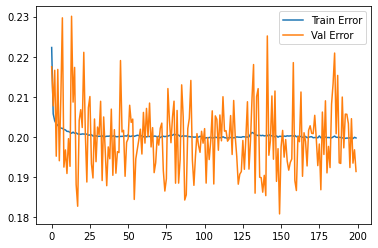

In [ ]:
plt.plot(hist['epoch'], hist['mae'],label='Train Error')
plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
plt.legend()
plt.show()

In [ ]:
normed_test_dataset = test_dataset[900:]

In [ ]:
normed_test_data = np.array([test_dataset.por[900:], test_dataset.res[900:]]).transpose()

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

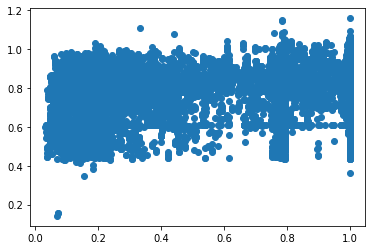

In [ ]:
plt.scatter(test_labels[900:], test_predictions)